In [2]:
import os
os.environ["KERAS_BACKEND"] = "torch" # alternatively you can use jax or tensorflow as the backend (see installation instructions in keras documentation)
import keras

import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split # helpful for splitting data into training and testing sets
from sklearn.preprocessing import StandardScaler, MinMaxScaler # helpful for scaling data to be between 0 and 1 or have a mean of 0 and standard deviation of 1


In [4]:
file_path = '/Users/ctychen/Desktop/N3AS/spectrum_data/'
#reloading data
parameters = np.concatenate([np.load(file_path + "atm_retr_params_12800_"+str(i)+".npy") for i in range(12)])
spectra_set = np.concatenate([np.load(file_path + "atm_retr_data_12800_"+str(i)+".npy") for i in range(12)])

#take the log of the spectra - seems like this helped a lot with feature identification
spectra_set = np.log(spectra_set)

parameters = parameters[~np.isnan(spectra_set).any(axis=1)]
spectra_set = spectra_set[~np.isnan(spectra_set).any(axis=1)]

print(parameters.shape)
print(spectra_set.shape)

(153590, 16)
(153590, 947)


In [9]:
n_samples = parameters.shape[0]
n_features = 947 #this is really arbitrary

#splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(parameters, spectra_set, test_size=0.2)

# scale data
xscaler = MinMaxScaler() #not sure if this is the best scaler to use, but just testing it out
#for the autoencoder though, we only need y, which is the spectra
yscaler = StandardScaler()

#don't actually need this for the autoencoder
X_train = xscaler.fit_transform(X_train)
X_test = xscaler.transform(X_test)

#for the autoencoder - want to predict y with y (the spectra with themselves)
y_train = yscaler.fit_transform(y_train)
y_test = yscaler.transform(y_test)

Parameters example: [0.16815556 0.10502379 0.84259803 0.31346532 0.31394243 0.82458676
 0.86147334 0.10687175 0.16582331 0.71445354 0.88450206 0.95384656
 0.52747792 0.59010382 0.39913657 0.85804306], length: 16


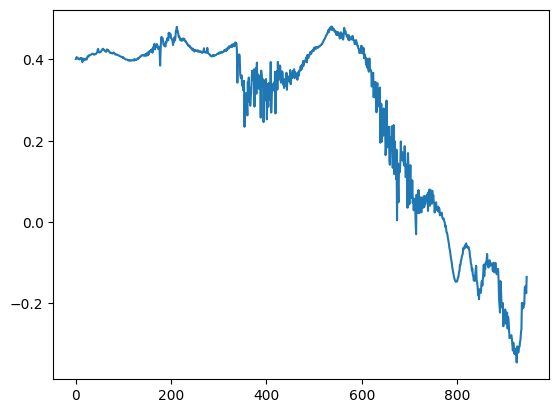

In [8]:
#plot some example training data to check
#parameters are the input, spectra are the output
print(f'Parameters example: {X_train[0]}, length: {len(X_train[0])}')   

plt.plot(y_train[0])
plt.show()

In [10]:
# FROM NN EXAMPLE CODE
# create an autoencoder

#everything below may be subject to change as we try running this model
inp = keras.layers.Input(shape=(n_features,)) # input layer with n_features neurons
x = keras.layers.Dense(64, activation="relu")(inp) # 64 neurons with relu activation function
x = keras.layers.Dense(32, activation="relu")(x) # 32 neurons with relu activation function
x = keras.layers.Dense(8, activation="relu")(x) # 8 neurons with relu activation function (bottleneck layer)
x = keras.layers.Dense(32, activation="relu")(x) # 32 neurons with relu activation function
x = keras.layers.Dense(64, activation="relu")(x) # 64 neurons with relu activation function
out = keras.layers.Dense(n_features)(x) # output layer with n_features neurons

autoencoder = keras.models.Model(inp, out) # create model with input and output layers

# compile model
autoencoder.compile(optimizer="adam", loss="mean_squared_error") # use adam optimizer and mean squared error loss function

# print model summary
autoencoder.summary()

# train model with training data and validate with testing data (early stopping is used to avoid overfitting)
history = autoencoder.fit(y_train, y_train, epochs=500, batch_size=32, validation_data=(y_test, y_test),
                callbacks=[keras.callbacks.EarlyStopping(patience=5)]) # this stops training if the validation loss does not decrease for 5 epochs to avoid overfitting
# notice that the input and output data are the same

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 947)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        60,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 947)            │        61,555 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 126,971 (495.98 KB)

 Trainable params: 126,971 (495.98 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
3840/3840 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.0590 - val_loss: 0.0048
Epoch 2/500
3840/3840 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.0072 - val_loss: 0.0029
Epoch 3/500
3840/3840 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.0060 - val_loss: 0.0058
Epoch 4/500
3840/3840 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.0061 - val_loss: 0.0030
Epoch 5/500
3840/3840 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.0038 - val_loss: 0.0022
Epoch 6/500
3840/3840 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.0073 - val_loss: 0.0046
Epoch 7/500
3840/3840 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.0043 - val_loss: 0.0027
Epoch 8/500
3840/3840 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.0047 - val_loss: 0.0022
Epoch 9/500
3840/3840 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.0034 - val_loss: 0.0031
Epoch 10/500
3840/3840 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.0032 - val_loss: 0.0023
Epoch 11/500
3840/3840 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.0029 - val_loss: 0.0020
Epoch 12/500
38